In this notebook, we implement Feature detection.

Feature Detection includes 
1. Corner detection
2. Edge detection

This implementation is performed using the research by Harris et al. from 1988.

The code in this file is taken from the tutorial class of Computer vision taught at FAU, Erlangen.

**What is Feature Detection?**

It is a process of identifying and locating specific patterns with in the image. These patters are also called features.

The features in the image, include points, edges, corners etc...

In this tutorial, we detect only edges and corners.

**Edges:** Boundaries between different regions, where there is a sharp change in intensity.

**corners:** intersection of two edges, usually representing a significant change in direction

**why do we perform it ?**

1. Object Recognition
2. Image Matching and Alignment
3. Tracking
4. Structure from Motion
5. Image Compression
6. Segmentation and Object Boundaries

**Common Feature Detection Techniqies**

1. Harris Corner Detector
2. SIFT
3. SURF
4. Canny Edge detector

Feature detection is performed in computer vision because these features are often more stable and reliable than raw pixel values. By focusing on these significant parts of an image, we can achieve more robust and accurate results in various computer vision tasks.








**Harris Corner Detector** : The Harris Corner Detector is a popular feature detection algorithm used in computer vision to identify corner points within an image. It was developed by Chris Harris and Mike Stephens in 1988 and is particularly known for its efficiency in detecting corners, which are points where there is a significant change in intensity in multiple directions. Corners are often considered strong features because they are invariant to changes in rotation and scale, making them useful for tasks like object recognition, image matching, and motion tracking.

**Steps performed**
1. Image Gradient Calculation
2. Calculate Moment Matrix
3. Compute Corner response Function 
4. Thresholding and Non Maximal Suppression
5. Corner Detection.

# Import Necessary Libraries

In [49]:
import numpy as np 
import os 
import cv2
import sys
from typing import Tuple
import matplotlib.pyplot as plt
%matplotlib inline

## Reading image and preprocessing

In [50]:
input_path = os.path.join("resources","input.jpg")
ouput_path = os.path.join(os.getcwd(),"results_FeatureDetection")

In [51]:
input = cv2.imread(input_path, cv2.IMREAD_COLOR)
gray_float_image = cv2.cvtColor(input, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

## Computing Harris Response

In [52]:
def compute_harris_response(I: np.array, k: float=0.06) -> Tuple[np.array]:
    assert I.dtype == np.float32 
    
    # 1. compute Idx and Idy
    Idx = cv2.Sobel(I, cv2.CV_64F, 1, 0)
    Idy = cv2.Sobel(I, cv2.CV_64F, 0, 1)

    # 2. calculate Ixx, Iyy, Ixy
    Ixx = Idx*Idx
    Iyy = Idy*Idy
    Ixy = Idx*Idy 

    # 3. Gaussian Blur
    A = cv2.GaussianBlur(Ixx,ksize=(3,3),sigmaX=1)
    B = cv2.GaussianBlur(Iyy,ksize=(3,3), sigmaX=1)
    C = cv2.GaussianBlur(Ixy, ksize=(3,3), sigmaX=1)

    # 4. Calculate harris detection response
    T = [[A, C], [C, B]]
    det_T = A * B - C * C 
    
    trace_T = A + B 

    R = det_T - k * (trace_T ** 2)


    return R, A, B, C, Idx, Idy


In [53]:
R, A, B, C, Idx, Idy = compute_harris_response(gray_float_image, k=.06)

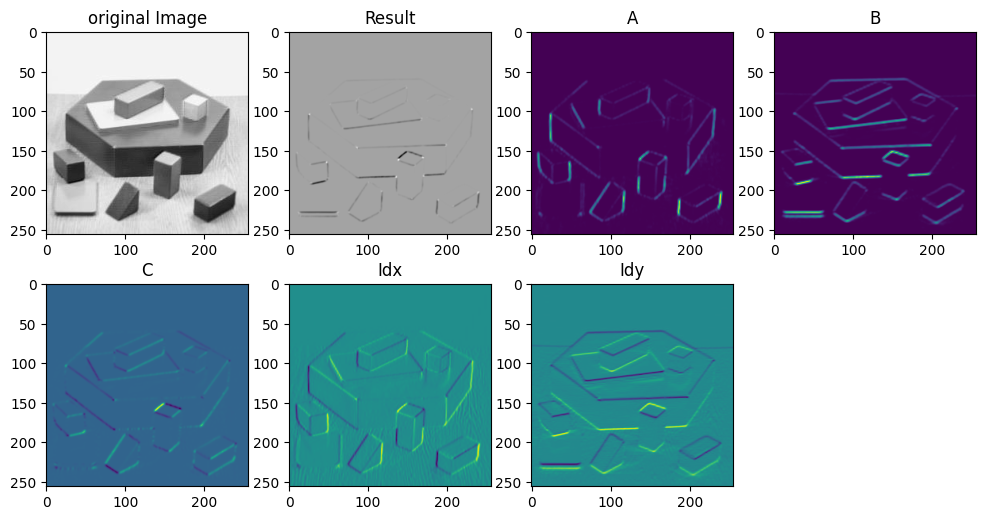

In [54]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(2,4,1)
plt.imshow(gray_float_image, cmap="gray")
plt.title("original Image")

fig.add_subplot(2,4,2)
plt.imshow(R, cmap="gray")
plt.title("Result")

fig.add_subplot(2,4,3)
plt.imshow(A)
plt.title("A")

fig.add_subplot(2,4,4)
plt.imshow(B)
plt.title("B")

fig.add_subplot(2,4,5)
plt.imshow(C)
plt.title("C")

fig.add_subplot(2,4,6)
plt.imshow(Idx)
plt.title("Idx")

fig.add_subplot(2,4,7)
plt.imshow(Idy)
plt.title("Idy")
plt.show()

## Corner Detection 

In [55]:
def detect_corners(R: np.array, threshold: float= 0.1) -> Tuple[np.array, np.array]:
    
    # 1. pad the response image to facilitate vectorization
    padded_R = np.pad(R, 1, mode="constant")

    # 2. Create one image for every offset in the 3x3 neighborhood
    shifts = [
        (0, 0), (-1, -1), (-1, 0), (-1, 1),
        (0,-1), (0, 1), (1, -1), (1, 1)
    ]

    neighbors = [padded_R[1+dy:R.shape[0] + 1 + dy, 1 + dx:R.shape[1] + 1 + dx] for dx, dy in shifts]

    # 3. Compute the greatest neighbor of every pixel
    max_neighbor = np.maximum.reduce(neighbors)

    # 4. Compute a boolean image with only all key-points set to true
    is_keypoint = (R>threshold) & (R > max_neighbor)

    # 5. Compute the locations of the keypoints from the boolean image
    keypoint_y, keypoint_x = np.nonzero(is_keypoint)

    return keypoint_x, keypoint_y

In [56]:
def draw_points(input_image: np.array, points: Tuple[np.array, np.array], color: Tuple[int, int, int]) -> np.array:
    """Draws a set of points on a color image.

    Args:
        input_image: A BGR byte image
        points: A tuple of np.array with the integer coordinates of the points to be rendered
        color: A tuple with red, green, and blue values in the range [0-255]

    Returns:
        A BGR byte image
    """
    assert input_image.dtype == np.uint8 and len(input_image.shape) == 3
    x_points, y_points = points
    assert x_points.shape == y_points.shape and len(y_points.shape) == 1
    key_points = [cv2.KeyPoint(float(x_points[n]), float(y_points[n]), 1) for n in range(len(x_points))]
    return cv2.drawKeypoints(input_image, key_points, outImage=None, color=color)

In [59]:
points = detect_corners(R, threshold=.1)
drawn_points = draw_points(input, points, color=(0, 255, 0))

Text(0.5, 1.0, 'Key points')

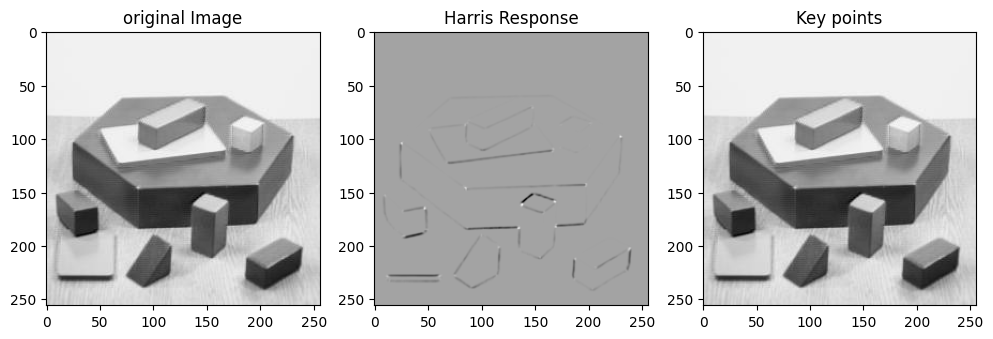

In [60]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1,3,1)
plt.imshow(input, cmap="gray")
plt.title("original Image")

fig.add_subplot(1,3,2)
plt.imshow(.5 + R, cmap="gray")
plt.title("Harris Response")

fig.add_subplot(1,3,3)
plt.imshow(drawn_points)
plt.title("Key points")

In [29]:
def detect_edges(R: np.array, edge_threshold: float = -0.01) -> np.array:
    
    # Step 1 (recommended): Pad the response image to facilitate vectorization
    padded_R = np.pad(R, pad_width=1, mode='constant', constant_values=np.inf)

    # Step 2 (recommended): Calculate significant response pixels
    significant_pixels = R < edge_threshold

    # Step 3 (recommended): Create two images with the smaller x-axis and y-axis neighbors respectively
    left = padded_R[1:-1, :-2]  # Shifted left
    right = padded_R[1:-1, 2:]  # Shifted right
    up = padded_R[:-2, 1:-1]    # Shifted up
    down = padded_R[2:, 1:-1]   # Shifted down

    # Step 4 (recommended): Calculate pixels that are lower than either their x-axis or y-axis neighbors
    min_x_axis = np.minimum(left, right)
    min_y_axis = np.minimum(up, down)
    axis_minimal = (R < min_x_axis) | (R < min_y_axis)

    # Step 5 (recommended): Calculate valid edge pixels by combining significant and axis_minimal pixels
    edge_pixels = significant_pixels & axis_minimal

    return edge_pixels

In [30]:
def draw_mask(input_image: np.array, mask: np.array, color: Tuple[int, int, int]) -> np.array:
    assert input_image.dtype == np.uint8 and len(input_image.shape) == 3
    keep_pixels = ~mask[:, :, None]
    img_b, img_g, img_r = input_image[:, :, : 1], input_image[:, :, 1: 2], input_image[:, :, 2:]
    color_r, color_g, color_b = color
    img_r = img_r * keep_pixels + color_r * mask[:, :, None]
    img_g = img_g * keep_pixels + color_g * mask[:, :, None]
    img_b = img_b * keep_pixels + color_b * mask[:, :, None]
    result = np.concatenate([img_b, img_g, img_r], axis=2).astype(np.uint8)
    return result

In [31]:
edges = detect_edges(R, edge_threshold=-.01)
drawn_edges = draw_mask(input, edges, color=(255, 0, 0))

Text(0.5, 1.0, 'Drawn Edges')

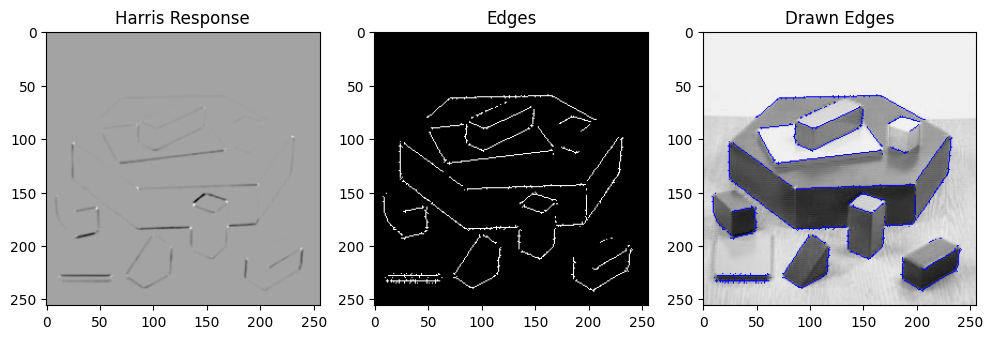

In [32]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1,3,1)
plt.imshow(.5 + R, cmap="gray")
plt.title("Harris Response")

fig.add_subplot(1,3,2)
plt.imshow(edges, cmap="gray")
plt.title("Edges")

fig.add_subplot(1,3,3)
plt.imshow(drawn_edges)
plt.title("Drawn Edges")